In [0]:
!pip install dgl

     |████████████████████████████████| 3.0MB 2.8MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


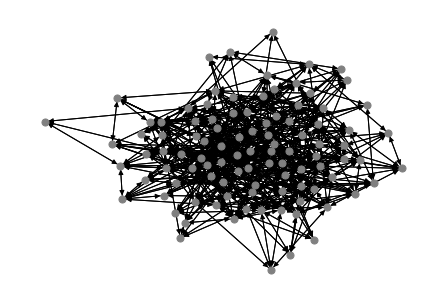

In [0]:
#creating the graph
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

In [0]:
#storing the node's value as 1/N
g.ndata['pv'] = torch.ones(N) / N

In [0]:
#storing the node's out degree as an out feature
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [0]:
#divides and passes the values to the neighbours
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In [0]:
#reduce function
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

In [0]:
#register the functions
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

In [0]:
#one pagerank iteration
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

In [0]:
#comouting on a batch
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

In [0]:
def pagerank_level2(g):
    g.update_all()

In [0]:
#DGL Builtin functions
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [0]:
for k in range(K):
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0089, 0.0167, 0.0106, 0.0056, 0.0065, 0.0074, 0.0107, 0.0058, 0.0128,
        0.0114, 0.0072, 0.0112, 0.0098, 0.0072, 0.0112, 0.0107, 0.0097, 0.0098,
        0.0091, 0.0097, 0.0120, 0.0114, 0.0136, 0.0081, 0.0040, 0.0090, 0.0057,
        0.0098, 0.0131, 0.0097, 0.0097, 0.0079, 0.0091, 0.0118, 0.0116, 0.0113,
        0.0106, 0.0098, 0.0088, 0.0113, 0.0089, 0.0058, 0.0088, 0.0128, 0.0097,
        0.0100, 0.0147, 0.0100, 0.0130, 0.0040, 0.0089, 0.0162, 0.0098, 0.0140,
        0.0132, 0.0087, 0.0098, 0.0089, 0.0057, 0.0124, 0.0066, 0.0129, 0.0092,
        0.0065, 0.0122, 0.0105, 0.0098, 0.0083, 0.0057, 0.0114, 0.0090, 0.0129,
        0.0147, 0.0141, 0.0065, 0.0048, 0.0120, 0.0085, 0.0091, 0.0098, 0.0098,
        0.0110, 0.0113, 0.0065, 0.0082, 0.0065, 0.0158, 0.0115, 0.0082, 0.0063,
        0.0131, 0.0087, 0.0097, 0.0122, 0.0089, 0.0118, 0.0131, 0.0082, 0.0130,
        0.0166])
